## Mathematical Model


$ \textbf{Parameters:}$

$ c = [c_1, c_2] \quad \text{(Cost per unit for products 1 and 2 respectively)}$

$ \mu = [\mu_1, \mu_2] \quad \text{(Mean demand for products 1 and 2)}$

$ \delta = [\delta_1, \delta_2] \quad \text{(Base uncertainty in demand for products 1 and 2)}$

$ \text{Multiplier} \quad m \quad \text{(Uncertainty multiplier)}$


$ \textbf{Decision Variables:}$

$ x = [x_1, x_2] \quad \text{(Production quantities for products 1 and 2)}$

$ z \quad \text{(Worst-case scenario cost)}$

$ \textbf{Objective Function:}$

$ \min z$

$ \textbf{Constraints:}$

$ x_1 \geq \mu_1 - m \cdot \delta_1 \quad \text{(Demand lower bound for product 1)}$

$ x_2 \geq \mu_2 - m \cdot \delta_2 \quad \text{(Demand lower bound for product 2)}$

$ x_1 \leq \mu_1 + m \cdot \delta_1 \quad \text{(Demand upper bound for product 1)}$

$ x_2 \leq \mu_2 + m \cdot \delta_2 \quad \text{(Demand upper bound for product 2)}$

$ z \geq c_1 \cdot (x_1 + m \cdot \delta_1) + c_2 \cdot (x_2 + m \cdot \delta_2) \quad \text{(Worst-case cost constraint)}$



In [1]:
import cvxpy as cp
import numpy as np

# Define the data for the problem
costs = np.array([20, 25])  # Cost per unit of products 1 and 2
mean_demand = np.array([100, 150])  # Mean demand for products 1 and 2
demand_uncertainty = np.array([10, 15])  # Uncertainty in demand for products 1 and 2

# Decision variables for production quantities
x = cp.Variable(2, nonneg=True)

# Additional decision variable for worst-case scenario cost
worst_case_cost = cp.Variable()

# Define the objective function (minimize the worst-case cost)
objective = cp.Minimize(worst_case_cost)

# Uncertainty model - here we assume demand can vary within +/- the uncertainty
uncertain_demand = cp.Parameter(2)

# Define constraints including the robust constraint
constraints = [
    x >= mean_demand - demand_uncertainty,  # Lower bound on production
    x <= mean_demand + demand_uncertainty,  # Upper bound on production
    worst_case_cost >= costs @ (x + uncertain_demand)  # Worst-case cost scenario
]

# Create problem and solve for different scenarios
problem = cp.Problem(objective, constraints)
optimal_productions = []
total_costs = []

for delta in [np.array([0, 0]), np.array([-10, -15]), np.array([10, 15])]:
    uncertain_demand.value = delta
    problem.solve(solver=cp.ECOS)  # Explicitly specifying the solver
    optimal_productions.append(x.value)
    total_costs.append(worst_case_cost.value)

print("Optimal production quantities for scenarios:", optimal_productions)
print("Total worst-case costs for scenarios:", total_costs)


(CVXPY) Aug 24 11:20:46 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Aug 24 11:20:46 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
Optimal production quantities for scenarios: [array([ 90.00000001, 134.99999998]), array([ 90.00000001, 134.99999998]), array([ 90.00000001, 134.99999998])]
Total worst-case costs for scenarios: [array(5174.99999992), array(4599.99999992), array(5749.99999993)]


/opt/anaconda3/envs/OR/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


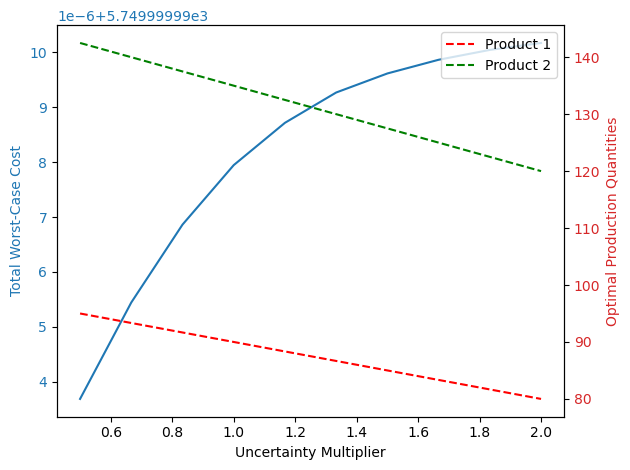

In [2]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Define the base data for the problem
costs = np.array([20, 25])  # Cost per unit of products 1 and 2
mean_demand = np.array([100, 150])  # Mean demand for products 1 and 2
base_uncertainty = np.array([10, 15])  # Base uncertainty in demand for products 1 and 2

# Range of uncertainty multipliers to test
uncertainty_multipliers = np.linspace(0.5, 2.0, 10)

# Store results
optimal_productions = []
total_costs = []

# Define the problem structure
x = cp.Variable(2, nonneg=True)
worst_case_cost = cp.Variable()
uncertain_demand = cp.Parameter(2)
objective = cp.Minimize(worst_case_cost)
constraints = [
    x >= mean_demand - uncertain_demand,
    x <= mean_demand + uncertain_demand,
    worst_case_cost >= costs @ (x + uncertain_demand)
]

problem = cp.Problem(objective, constraints)

# Perform sensitivity analysis
for multiplier in uncertainty_multipliers:
    uncertain_demand.value = base_uncertainty * multiplier
    problem.solve()
    optimal_productions.append(x.value.copy())
    total_costs.append(worst_case_cost.value)

# Visualization
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Uncertainty Multiplier')
ax1.set_ylabel('Total Worst-Case Cost', color=color)
ax1.plot(uncertainty_multipliers, total_costs, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Optimal Production Quantities', color=color)
ax2.plot(uncertainty_multipliers, [prod[0] for prod in optimal_productions], '--', label='Product 1', color='red')
ax2.plot(uncertainty_multipliers, [prod[1] for prod in optimal_productions], '--', label='Product 2', color='green')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()
plt.show()
